# Keyword-MLP Tutorial

This notebook will guide you through the steps to training and running inference on Google Speech Commands V2 (35) with the [Keyword-MLP](https://github.com/AI-Research-BD/Keyword-MLP.git) repository.

## Setup

### 1. Clone the repository

In [1]:
!git clone https://github.com/AI-Research-BD/Keyword-MLP.git

Cloning into 'Keyword-MLP'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 44 (delta 5), reused 30 (delta 2), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [2]:
cd Keyword-MLP

/content/Keyword-MLP


### 2. Install requirements

In [ ]:
!pip install -qr requirements.txt

### 3. Download the Google Speech Commands V2 dataset

We'll be saving it to the `./data/` folder.

In [ ]:
!sh ./download_gspeech_v2.sh ./data/

In [5]:
!ls data

_background_noise_  five     left     README.md		tree
backward	    follow   LICENSE  right		two
bed		    forward  marvin   seven		up
bird		    four     nine     sheila		validation_list.txt
cat		    go	     no       six		visual
dog		    happy    off      stop		wow
down		    house    on       testing_list.txt	yes
eight		    learn    one      three		zero


As you can see, the dataset provides a `validation_list.txt` and a `testing_list.txt` as the split. We'll run a simple script `make_data_list.py` to also generate a `training_list.txt`, as well as a `label_map.json` that maps numeric indices to class labels.

In [6]:
!python make_data_list.py -v ./data/validation_list.txt -t ./data/testing_list.txt -d ./data/ -o ./data/

Number of training samples: 84843
Number of validation samples: 9981
Number of test samples: 11005
Saved data lists and label map.


## Using Pre-trained Models for Inference

The Keyword-MLP repository provides a pretrained checkpoint. We can use this checkpoint to run some inferences, before we look at training.

### 4. Downloading Pre-Trained Model

In [ ]:
!wget -O "kwmlp_pretrained.ckpt" "https://drive.google.com/uc?id=1lywXTaJjPud41f3G_NmuRHzhDY8uNbWe&export=download"

### 5. Exploring Some Test Set Audio Files

Let's take a few files from the test set, take a look at their melspectrograms, and listen to them.

In [8]:
with open("data/testing_list.txt", "r") as f:
  test_samples = f.read().rstrip().split("\n")

samples = test_samples[:3]
print(samples)

['./data/left/5828dfa2_nohash_0.wav', './data/down/cfbedff9_nohash_3.wav', './data/one/fb7eb481_nohash_3.wav']


In [9]:
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa

def show_melspec(audio_path):
    print(f"Showing {audio_path}")
    audio_settings = {
        "sr": 16000,
        "n_mels": 40,
        "n_fft": 480,
        "win_length": 480,
        "hop_length": 160,
        "center": False
    }
    x = librosa.load(audio_path, audio_settings["sr"])[0]
    x = librosa.util.fix_length(x, audio_settings["sr"])
    x = librosa.feature.melspectrogram(y=x, **audio_settings)      
  
    plt.figure(figsize=(7, 5))
    plt.imshow(x, cmap="hot")
    plt.show()



Showing ./data/left/5828dfa2_nohash_0.wav


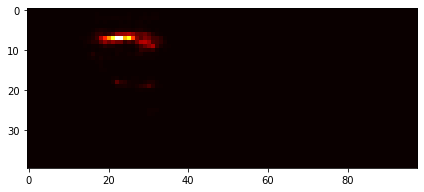

In [10]:
show_melspec(samples[0])
Audio(samples[0])

Showing ./data/down/cfbedff9_nohash_3.wav


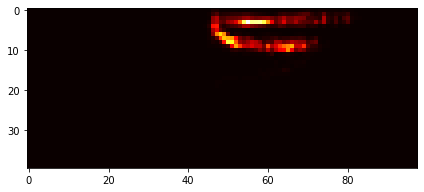

In [11]:
show_melspec(samples[1])
Audio(samples[1])

Showing ./data/one/fb7eb481_nohash_3.wav


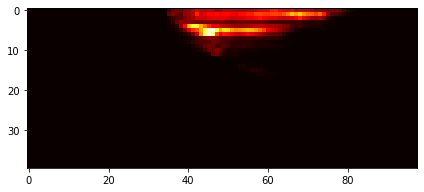

In [12]:
show_melspec(samples[2])
Audio(samples[2])

### 6. Using Inference Scipts

There are two inference scripts provided in the repository:
- `inference.py`
- `window_inference.py`.

We'll be using the pretrained model we downloaded earlier to test these inference scripts.

**Using `inference.py`:**

For simple short clips that are about 1s, such as the audios in the Speech Commands dataset, you can simply use `inference.py` to get predictions. It can be run on a single audio clip, as well as a folder containing several audio clips.

Let us first try **inferencing on a single short clip**:

In [13]:
!python inference.py --conf sample_configs/base_config.yaml \
                     --ckpt kwmlp_pretrained.ckpt \
                     --inp {samples[0]} \
                     --out outputs/single_preds/ \
                     --lmap label_map.json \
                     --device cpu             # you can also use cuda

100% 1/1 [00:00<00:00,  4.45it/s]
Saved preds to outputs/single_preds/preds.json


Let us check the prediction output:

In [14]:
!cat outputs/single_preds/preds.json

{"./data/left/5828dfa2_nohash_0.wav": "left"}

Seems like it's correct!

Similarly, you can also provide **a folder containing multiple audio wavs** to the `--inp` argument, instead of a single audio path. Let's take the previously seen first 3 audios in testing list and put them in a folder:

In [15]:
# Moving multiple audios to a single folder "samples"
!cat data/testing_list.txt | head -n 3
!mkdir -p samples/
!cp $(cat data/testing_list.txt | head -n 3) samples/

./data/left/5828dfa2_nohash_0.wav
./data/down/cfbedff9_nohash_3.wav
./data/one/fb7eb481_nohash_3.wav


In [16]:
# Run inference
!python inference.py --conf sample_configs/base_config.yaml \
                     --ckpt kwmlp_pretrained.ckpt \
                     --inp samples/ \
                     --out outputs/folder_preds/ \
                     --lmap label_map.json \
                     --device cpu

100% 3/3 [00:00<00:00, 74.34it/s]
Saved preds to outputs/folder_preds/preds.json


The outputs are in a similar json format.

In [17]:
!cat outputs/folder_preds/preds.json

{"samples/fb7eb481_nohash_3.wav": "one", "samples/5828dfa2_nohash_0.wav": "left", "samples/cfbedff9_nohash_3.wav": "down"}

*If you are running inference on a large number of clips, you can also use the **--batch_size** argument.* By default, batch size is set to 1 during inference.



---



---

**Using window_inference.py:**

In real life use-case, audios are typically much longer than 1s. To get predictions from long audios, we thus need to run multiple inferences on various "chunks" or "windows" in that audio clip.

![window.png](https://raw.githubusercontent.com/ID56/Torch-KWT/main/resources/window.png)

While we don't have a long clip here, we can try **concatenating the three wavs** inside the `samples/` folder we made above into **a single 3s long audio clip**.

In [18]:
from IPython.display import Audio
import soundfile as sf
import numpy as np
import librosa
import glob

def concat_audio(audio_folder):
    audio_list = []
    for audio_file in glob.glob(f"{audio_folder}/*.wav"):
       x = librosa.load(audio_file, sr=16000)[0]
       x = librosa.util.fix_length(x, 16000)
       audio_list.append(x)
    long_audio = np.hstack(audio_list)
    sf.write("long_audio.wav", long_audio, 16000)

concat_audio("samples/")
Audio("long_audio.wav")

Now let's run `window_inference.py`. It can be run in three modes:

- multi: saves all found predictions (default)
- max: saves the "most confident" prediction (outputs only a single 'clipwise; prediction for the whole clip)
- n_voting: saves the "most frequent" prediction (outputs only a single 'clipwise' prediction for the whole clip)

The `multi` mode is probably the most useful, and is thus the default mode. We will run inferences over **1s windows**, and **slide the window by 0.5s**. We will only keep the predictions with **confidence over 0.85**.

In [19]:
!python window_inference.py --conf sample_configs/base_config.yaml \
                     --ckpt kwmlp_pretrained.ckpt \
                     --inp long_audio.wav \
                     --out outputs/long_audio/ \
                     --lmap label_map.json \
                     --device cpu \
                     --wlen 1 \
                     --stride 0.5 \
                     --thresh 0.85 \
                     --mode multi

Saved preds to outputs/long_audio/preds_clip.json


In [20]:
!cat outputs/long_audio/preds_clip.json

{"long_audio.wav": [["one", 0.9001082181930542, 0.0, 16000.0], ["left", 0.8915184140205383, 16000.0, 32000.0], ["down", 0.9065350890159607, 32000.0, 48000.0]]}

- Outputs are in the form: **[class, confidence, start_sample, end_sample]**. (If you divide sample by sample rate, you can get the time range)
- It is possible that sometimes two windows may both partially fall on the same keyword instance. In such a case, you may get two consecutive predictions of the same class with some overlap. *(Like, nine-1s-2s and nine-1.5s-2.5s.)*
- Similar to `inference.py` the `--inp` argument in `window_inference.py` can also work with a folder of audio files
- You can also set the --batch_size argument for faster inference on GPU

## Training

For training, we only need to provide the config file.

### 9. Setting Up Your Config File

For this example, we'll follow the `sample_configs/base_config.yaml`. In fact, you should be able to use this config to reproduce the results of the provided pretrained checkpoint if you follow the exact settings (training for 140 epochs @ batch_size = 256).

We'll be training for 10 epochs in this example.

You can also use [wandb](wandb.ai) to log your runs. Either provide a path to a txt file containing your API key, or set the env variable "WANDB_API_KEY", like:

```
os.environ["WANDB_API_KEY"] = "yourkey"
```

We will not be using wandb in this example, but feel free to try it.

In [21]:
conf_str = """# sample config to run a demo training of 10 epochs

data_root: ./data/
train_list_file: ./data/training_list.txt
val_list_file: ./data/validation_list.txt
test_list_file: ./data/testing_list.txt
label_map: ./data/label_map.json

exp:
    wandb: False
    wandb_api_key:
    proj_name: torch-kw-mlp
    exp_dir: ./runs
    exp_name: kw-mlp-0.1.0
    device: auto
    log_freq: 20  # steps
    log_to_file: False
    log_to_stdout: True
    val_freq: 1   # epochs
    n_workers: 2
    pin_memory: True
    cache: 2      # 0 -> no cache | 1 -> cache wavs | 2 -> cache specs; stops wav augments
    

hparams:
    restore_ckpt:
    seed: 0
    batch_size: 256
    start_epoch: 0
    n_epochs: 10
    l_smooth: 0.1

    audio:
        sr: 16000
        n_mels: 40
        n_fft: 480
        win_length: 480
        hop_length: 160
        center: False
    
    model:
        type: kw-mlp 
        input_res: [40, 98]
        patch_res: [40, 1]
        num_classes: 35
        channels: 1
        dim: 64
        depth: 12
        pre_norm: False
        prob_survival: 0.9

    optimizer:
        opt_type: adamw
        opt_kwargs:
          lr: 0.001
          weight_decay: 0.1
    
    scheduler:
        n_warmup: 10
        max_epochs: 140
        scheduler_type: cosine_annealing

    augment:
        spec_aug:
            n_time_masks: 2
            time_mask_width: 25
            n_freq_masks: 2
            freq_mask_width: 7"""

!mkdir -p configs
with open("configs/kwmlp_colab.yaml", "w+") as f:
  f.write(conf_str)

### 10. Initiating Training

Make sure you are using a GPU runtime.

In order to train to a full 140 epochs like the paper, on free resources, we need to cut down on disk I/O and audio processing time. So, we'll preemptively convert all our `.wav` files into MFCCs of shape `(40, 98)` and keep them stored in memory. This caching process may take ~6 minutes.

We'll be using only spectral augmentation, like the paper.



> Note: You may notice a "Warning: Leaking Caffe2 thread-pool after fork." message after each epoch. It seems to be an existing torch-1.9 issue, which you can ignore. [See more here.](https://github.com/pytorch/pytorch/issues/57273)





In [22]:
!python train.py --conf configs/kwmlp_colab.yaml

Set seed 0
Using settings:
 data_root: ./data/
exp:
  cache: 2
  device: &id001 !!python/object/apply:torch.device
  - cuda
  exp_dir: ./runs
  exp_name: kw-mlp-0.1.0
  log_freq: 20
  log_to_file: false
  log_to_stdout: true
  n_workers: 2
  pin_memory: true
  proj_name: torch-kw-mlp
  save_dir: ./runs/kw-mlp-0.1.0
  val_freq: 1
  wandb: false
  wandb_api_key: null
hparams:
  audio:
    center: false
    hop_length: 160
    n_fft: 480
    n_mels: 40
    sr: 16000
    win_length: 480
  augment:
    spec_aug:
      freq_mask_width: 7
      n_freq_masks: 2
      n_time_masks: 2
      time_mask_width: 25
  batch_size: 256
  device: *id001
  l_smooth: 0.1
  model:
    channels: 1
    depth: 12
    dim: 64
    input_res:
    - 40
    - 98
    num_classes: 35
    patch_res:
    - 40
    - 1
    pre_norm: false
    prob_survival: 0.9
    type: kw-mlp
  n_epochs: 10
  optimizer:
    opt_kwargs:
      lr: 0.001
      weight_decay: 0.1
    opt_type: adamw
  restore_ckpt: null
  scheduler:
    max

After training 10 epochs, we have a validation accuracy of **~91.6%** and a test accuracy of **~90.1%**.


In colab, it takes **~75 s** per epoch, with an additional **~3 s** for validation. To do a complete training like the paper (140 epochs) on colab, you'd thus need around **3 hours**.

You may also try training KW-MLP on Kaggle, which I've found to be notably faster. Full training takes around **2 hours** there.